Input Image:

In [25]:
from PIL import Image
import numpy as np
import math
import matplotlib.pyplot as plt

input_image = Image.open("WholeHouse.tif")
image_array = np.array(input_image)
height, width = image_array.shape

print(image_array)
print(f"Shape: {image_array.shape}")  #(height, width)

[[165 171 166 ... 138 141 131]
 [136 150 172 ... 127 128 125]
 [ 91 133 167 ... 122 122 123]
 ...
 [171 155 150 ... 146 148 144]
 [176 172 160 ... 147 146 140]
 [139 139 138 ... 140 139 139]]
Shape: (300, 800)


Save and Plot the results:

In [26]:
def show_results(output_array,output_image_name,input_image_array=input_image):
    Image.fromarray(output_array.astype(np.uint8)).save(output_image_name+"_image.bmp")
    plt.figure(figsize=(10, 5))
    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(np.array(input_image_array), cmap="gray")
    plt.title("Original Image", fontsize=16)
    plt.axis("off")
    # detector Image
    plt.subplot(1, 2, 2)
    plt.imshow(output_array, cmap="gray")
    plt.title(output_image_name+" Edge Detector", fontsize=16)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

Detect Edges Algorithm in Horizontal and Vertical Directions:

In [27]:
def detect_edges_in_2_directions(masks_2_directions,image_array):
    threshold = 0
    num_pixels = 0
    output_array = np.zeros_like(image_array)
    for row in range(1, height - 1):
        for column in range(1, width - 1):
            pixel_magnitude = 0
            mask_sum = []
            # Apply mask in 2 directions
            for direction, mask in enumerate(masks_2_directions):
                sum = 0
                for i in range(-1, 2):
                    for j in range(-1, 2):
                        sum += image_array[row + i, column + j] * mask[i + 1][j + 1]
                mask_sum.append(sum)
            # Calculate magnitude
            for value in mask_sum:
                pixel_magnitude += value ** 2
            pixel_magnitude = math.sqrt(pixel_magnitude)
            # Accumulate pixel magnitudes to calculate threshold
            threshold += pixel_magnitude
            num_pixels += 1
            output_array[row, column] = pixel_magnitude
    #Apply thresholding
    threshold /= num_pixels
    for row in range(height):
        for column in range(width):
            if output_array[row, column] > threshold:
                output_array[row, column] = 255
            else:
                output_array[row, column] = 0
    return output_array


Sobel Operator:

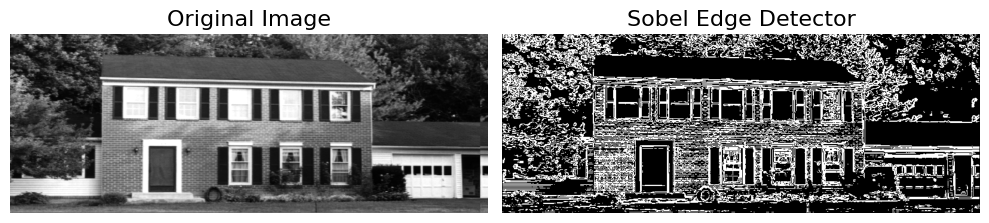

In [28]:
sobel_2_directions_mask = []

sobel_horizontal_mask = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
])
sobel_vertical_mask = np.array([
    [1,  2,  1],
    [0,  0,  0],
    [-1, -2, -1]
])
sobel_2_directions_mask.append(sobel_horizontal_mask)
sobel_2_directions_mask.append(sobel_vertical_mask)

sobel_array = detect_edges_in_2_directions(sobel_2_directions_mask,image_array)

show_results(output_array=sobel_array, output_image_name="Sobel")

Prewitt Operator:

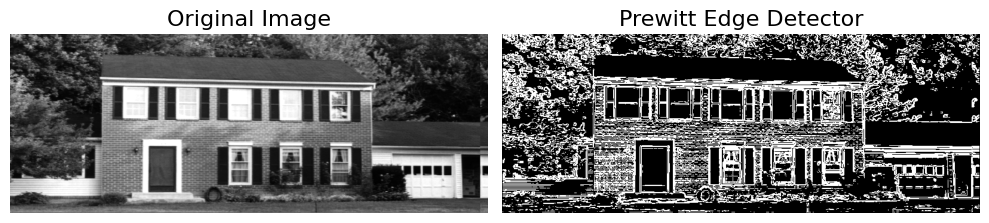

In [29]:
prewitt_2_directions_mask = []

prewitt_horizontal_mask = np.array([
    [-1, 0, 1],
    [-1, 0, 1],
    [-1, 0, 1]
])
prewitt_vertical_mask = np.array([
    [-1, -1, -1],
    [0, 0, 0],
    [1, 1, 1]
])
prewitt_2_directions_mask.append(prewitt_horizontal_mask)
prewitt_2_directions_mask.append(prewitt_vertical_mask)

prewitt_array = detect_edges_in_2_directions(prewitt_2_directions_mask,image_array)

show_results(output_array=prewitt_array, output_image_name="Prewitt")

Transform Mask In All 8 Directions:

In [30]:
def transform_mask(input_array):
    output_array = np.zeros_like(input_array)
    for i in range(3):
        for j in range(3):
            value = input_array[i,j]
            if i==1 and j==1: output_array[i,j] = value
            elif j==0 and i!=2: output_array[i+1,j] = value #down
            elif j==2 and i!=0: output_array[i-1,j] = value #up
            elif j!=2 and i==2: output_array[i,j+1] = value #left
            else: output_array[i,j-1] = value #right
    return output_array
def generate_mask_in_all_directions(input_array):
    masks=[]
    masks.append(input_array)
    for d in range(7):
        output_array = transform_mask(input_array)
        masks.append(output_array)
        input_array = output_array.copy()
    return masks


Detect Edges Algorithm in All 8 Directions:

In [31]:
def detect_edges_in_8_directions(masks_8_directions,image_array):
    threshold = 0
    output_array = np.zeros_like(image_array)
    for row in range(1, height - 1):
        for column in range(1, width - 1):
            pixel_magnitude = 0
            mask_sum = []
            # Apply mask in 8 directions
            for direction, mask in enumerate(masks_8_directions):
                sum = 0
                for i in range(-1, 2):
                    for j in range(-1, 2):
                        sum += image_array[row + i, column + j] * mask[i + 1][j + 1]
                pixel_magnitude = max(pixel_magnitude,sum)
            output_array[row, column] = pixel_magnitude
    #Apply thresholding
    threshold = np.max(output_array) * 0.5
    for row in range(height):
        for column in range(width):
            if output_array[row, column] > threshold:
                output_array[row, column] = 255
            else:
                output_array[row, column] = 0
    return output_array


Kirish Compass:

mask 0: [[5, 5, 5], [-3, 0, -3], [-3, -3, -3]]

mask 1: [[5, 5, -3], [5, 0, -3], [-3, -3, -3]]

mask 2: [[5, -3, -3], [5, 0, -3], [5, -3, -3]]

mask 3: [[-3, -3, -3], [5, 0, -3], [5, 5, -3]]

mask 4: [[-3, -3, -3], [-3, 0, -3], [5, 5, 5]]

mask 5: [[-3, -3, -3], [-3, 0, 5], [-3, 5, 5]]

mask 6: [[-3, -3, 5], [-3, 0, 5], [-3, -3, 5]]

mask 7: [[-3, 5, 5], [-3, 0, 5], [-3, -3, -3]]



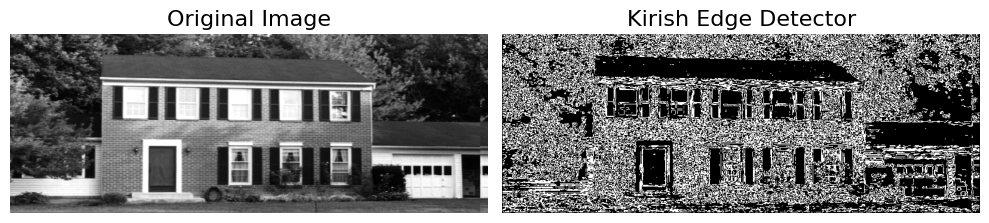

In [32]:
kirish_mask = np.array([
    [5, 5, 5],
    [-3, 0, -3],
    [-3, -3, -3]
])

kirish_8_directions = generate_mask_in_all_directions(kirish_mask)
for direction, mask in enumerate(kirish_8_directions):
    print(f"mask {direction}: {mask.tolist()}\n")
    
kirish_array = detect_edges_in_8_directions(kirish_8_directions,image_array)

show_results(output_array=kirish_array, output_image_name="Kirish")

Detect Edges Algorithm based on Substraction:

In [33]:
def detect_edges_by_substraction(operator,image_array,threshold=10):
    output_array = np.zeros_like(image_array)
    image_array = image_array.astype(np.int16)
    for row in range(1, height - 1):
        for column in range(1, width - 1):
            if operator=="homogeneity":
                center_pixel = image_array[row,column]
                max_difference = max(abs(center_pixel-image_array[row-1,column]),
                                    abs(center_pixel-image_array[row-1,column-1]),
                                    abs(center_pixel-image_array[row-1,column+1]),
                                    abs(center_pixel-image_array[row,column-1]),
                                    abs(center_pixel-image_array[row,column+1]),
                                    abs(center_pixel-image_array[row+1,column-1]),
                                    abs(center_pixel-image_array[row+1,column]),
                                    abs(center_pixel-image_array[row-1,column+1]))
            else: #difference operator
                max_difference = max(abs(image_array[row-1,column]-image_array[row+1,column]),
                                    abs(image_array[row-1,column-1]-image_array[row+1,column+1]),
                                    abs(image_array[row-1,column+1]-image_array[row+1,column-1]),
                                    abs(image_array[row,column-1]-image_array[row,column+1]))
            #Apply thresholding
            if max_difference>=threshold:
                output_array[row, column] = max_difference
    return output_array


Homogeneity Operator:

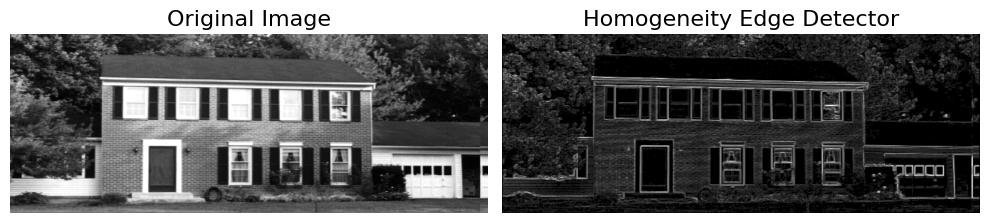

In [34]:
homogeneity_array = detect_edges_by_substraction("homogeneity",image_array)

show_results(output_array=homogeneity_array, output_image_name="Homogeneity")

Difference Operator:

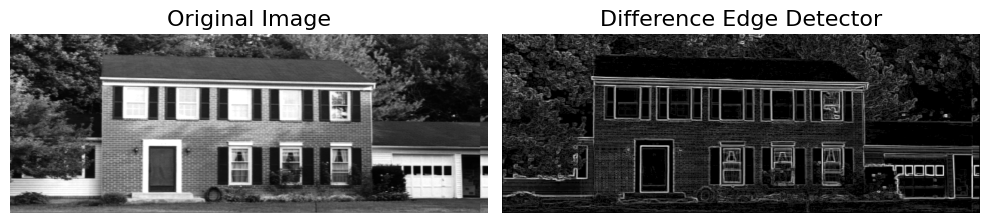

In [35]:
difference_array = detect_edges_by_substraction("difference",image_array)

show_results(output_array=difference_array, output_image_name="Difference")

Gaussians Filter Algorithm:

In [36]:
def apply_gaussian_mask(mask,image_array):
    mask_height, mask_width = mask.shape
    output_array = np.zeros_like(image_array).astype(np.float64)
    offset = int(mask_height // 2)
    for row in range(offset, height - offset):
        for column in range(offset, width - offset):
            convolution_sum = 0
            for i in range(-1*offset, offset+1):
                for j in range(-1*offset, offset+1):
                        convolution_sum += image_array[row+i, column+j] * mask[i+offset, j+offset]
                output_array[row, column] = min(max(convolution_sum, 0), 255)
    return output_array


Difference of Gaussians Algorithm with 7x7 and 9x9 Masks:

In [37]:
def apply_difference_of_gaussians(gaussian_mask_1,gaussian_mask_2):
    difference_of_gaussian_array = gaussian_mask_1 - gaussian_mask_2
    for row in range(0, height):
        for column in range(0, width):
                pixel_value = difference_of_gaussian_array[row, column]
                difference_of_gaussian_array[row, column] = min(max(pixel_value, 0), 255)
    return difference_of_gaussian_array


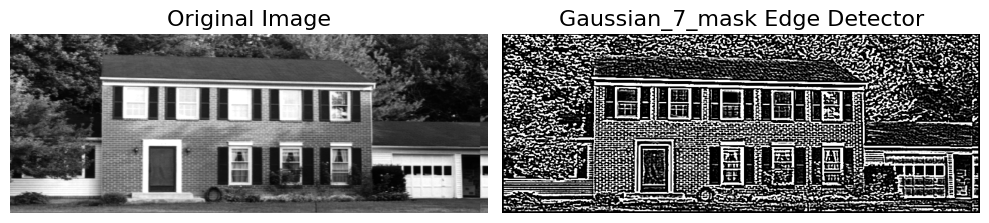

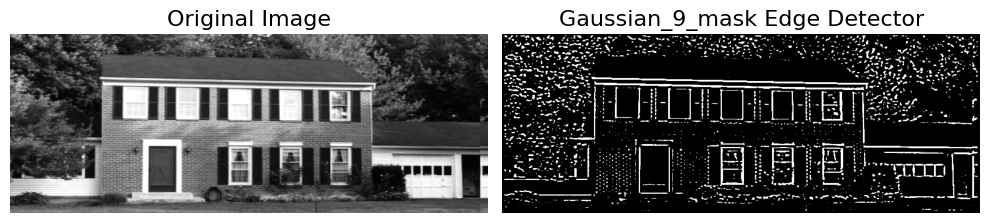

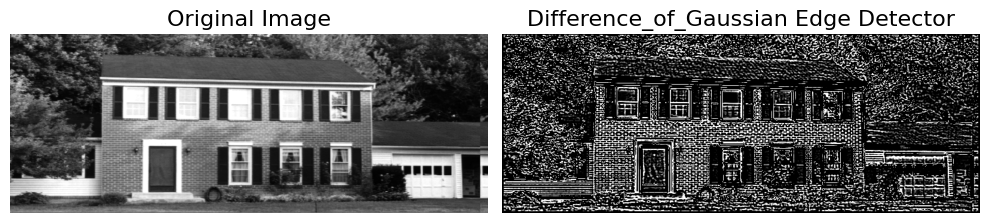

In [38]:
mask_7x7 = np.array([
    [0,  0, -1, -1, -1,  0,  0],
    [0, -2, -3, -3, -3, -2,  0],
    [-1, -3,  5,  5,  5, -3, -1],
    [-1, -3,  5, 16,  5, -3, -1],
    [-1, -3,  5,  5,  5, -3, -1],
    [0, -2, -3, -3, -3, -2,  0],
    [0,  0, -1, -1, -1,  0,  0]
])

mask_9x9 = np.array([
    [0,  0,  0, -1, -1, -1,  0,  0,  0],
    [0, -2, -3, -3, -3, -3, -3, -2,  0],
    [0, -3, -2, -1, -1, -1, -2, -3,  0],
    [-1, -3, -1,  9,  9,  9, -1, -3, -1],
    [-1, -3, -1,  9, 19,  9, -1, -3, -1],
    [-1, -3, -1,  9,  9,  9, -1, -3, -1],
    [0, -3, -2, -1, -1, -1, -2, -3,  0],
    [0, -2, -3, -3, -3, -3, -3, -2,  0],
    [0,  0,  0, -1, -1, -1,  0,  0,  0]
])

gaussian_7_mask_array = apply_gaussian_mask(mask_7x7,image_array)
gaussian_9_mask_array = apply_gaussian_mask(mask_9x9,image_array)
difference_of_gaussian_array = apply_difference_of_gaussians(gaussian_7_mask_array,gaussian_9_mask_array)

show_results(output_array=gaussian_7_mask_array, output_image_name="Gaussian_7_mask")
show_results(output_array=gaussian_9_mask_array, output_image_name="Gaussian_9_mask")
show_results(output_array=difference_of_gaussian_array, output_image_name="Difference_of_Gaussian")



Contrast-Based Edge Detector:

In [39]:
def apply_contrast_edge(mask, smoothing_mask,image_array):
    output_array = np.zeros_like(image_array)
    smoothing_mask = smoothing_mask.astype(float)
    for row in range(1, height - 1):
            for column in range(1, width - 1):
                edge_sum = 0
                smoothing_sum = 0
                for i in range(-1, 2):
                    for j in range(-1, 2):
                        edge_sum += image_array[row + i, column + j] * mask[i + 1][j + 1]
                        smoothing_sum += image_array[row + i, column + j] * smoothing_mask[i + 1][j + 1]
                smoothing_sum /= 9.0
                if smoothing_sum == 0:
                    smoothing_sum = 1
                output_array[row, column] = edge_sum / smoothing_sum
                if output_array[row, column] > 255:
                    output_array[row, column] = 255
                if output_array[row, column] < 0:
                    output_array[row, column] = 0
    return output_array

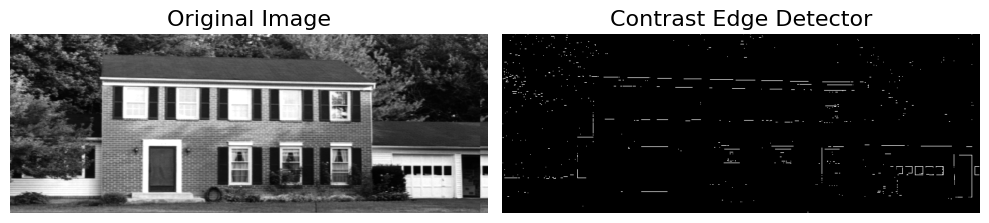

In [40]:
edge_detector_mask = np.array([
    [-1, 0, -1],
    [ 0, 4,  0],
    [-1, 0, -1]])
smoothing_mask = np.array([
    [1, 1, 1],
    [1, 1, 1],
    [1, 1, 1]])

contrast_array = apply_contrast_edge(edge_detector_mask, smoothing_mask,image_array)

show_results(output_array=contrast_array, output_image_name="Contrast")

Variance Edge Detector:

In [41]:
def apply_variance_edge(image_array):
    image_array = image_array.astype(np.float64)
    output_array = np.zeros_like(image_array)
    for row in range(1, height - 1):
        for column in range(1, width - 1):
            variance = 0
            center_pixel = image_array[row, column]
            for i in range(-1, 2):
                for j in range(-1, 2):
                    if i!=0 and j!=0:
                        neighbor = image_array[row + i, column + j]
                        variance += ((neighbor - center_pixel) ** 2)
            output_array[row, column] = np.sqrt(variance)
            if output_array[row, column] > 255:
                output_array[row, column] = 255
    return output_array

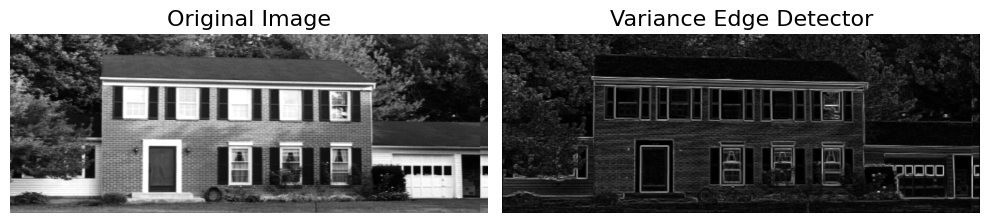

In [42]:
variance_array = apply_variance_edge(image_array)

show_results(output_array=variance_array, output_image_name="Variance")

Range Edge Detector:

In [43]:
def apply_range_edge(range_size,image_array):
    output_array = np.zeros_like(image_array)
    offset = int(range_size / 2)
    for row in range(offset, height - offset):
        for column in range(offset, width - offset):
            max_pixel = 0
            min_pixel = 300
            for i in range(-1*offset, offset+1):
                for j in range(-1*offset, offset+1):
                    max_pixel = max(max_pixel , image_array[row + i, column + j])
                    min_pixel = min(min_pixel , image_array[row + i, column + j])
            output_array[row, column] = max_pixel-min_pixel
    return output_array

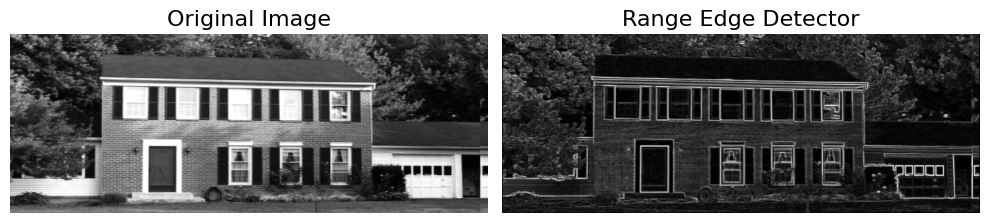

In [44]:
range_array = apply_range_edge(3,image_array)

show_results(output_array=range_array, output_image_name="Range")

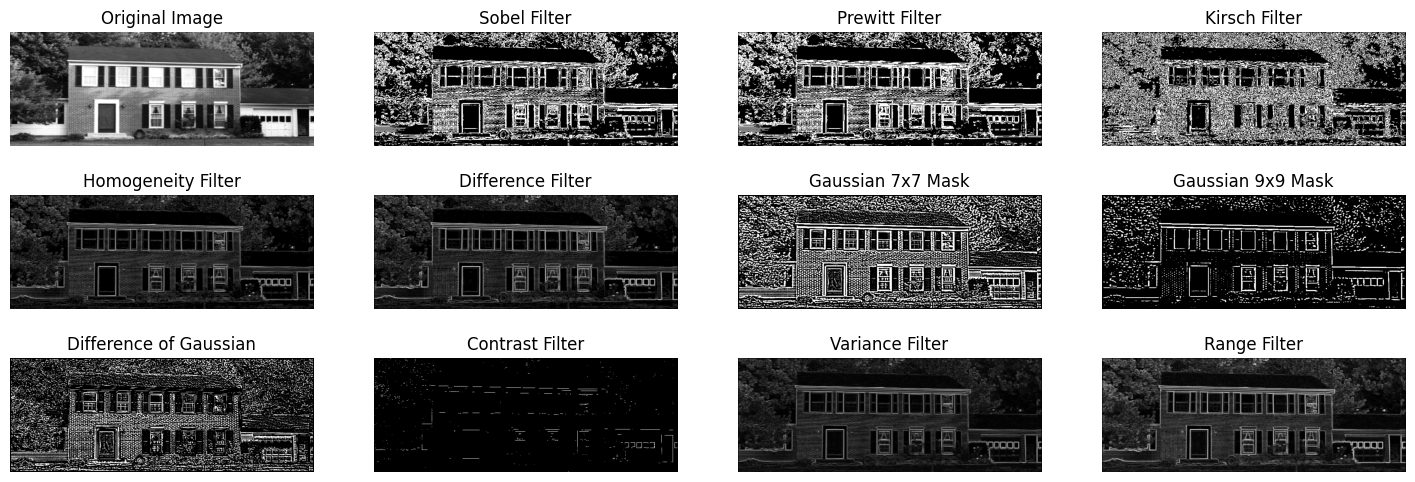

In [45]:
# Plot the results
images = [image_array,sobel_array,prewitt_array, kirish_array,homogeneity_array, difference_array,
        gaussian_7_mask_array, gaussian_9_mask_array, difference_of_gaussian_array,
        contrast_array, variance_array, range_array]

titles = ['Original Image', 'Sobel Filter', 'Prewitt Filter', 'Kirsch Filter', 'Homogeneity Filter', 'Difference Filter',
'Gaussian 7x7 Mask', 'Gaussian 9x9 Mask', 'Difference of Gaussian', 'Contrast Filter', 'Variance Filter', 'Range Filter']

fig, axes = plt.subplots(3, 4, figsize=(18, 6))

for ax, image, title in zip(axes.flatten(), images, titles):
    ax.imshow(image, cmap='gray')
    ax.axis('off')
    ax.set_title(title, fontsize=12)
